In [1]:
from utils.dataset import LQCDataset
from utils.device import get_device
from utils.job import Job
from utils.mlflow import set_mlflow_experiment
from models.textcnn import TextCNN

import torch
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn

import numpy as np
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
import mlflow


In [2]:
device = get_device()
device

'cuda'

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
set_mlflow_experiment("LQC-TextCNN")

MLFlow: 'LQC-TextCNN' not found !
MLFlow: Creating 'LQC-TextCNN' experiment...
MLFlow: 'LQC-TextCNN' created!
MLFlow: Setting 'LQC-TextCNN' experiment...
MLFlow: 'LQC-TextCNN' experiment is active !


In [5]:
raw_data = open("data/train_5500.label.txt", "r", encoding="latin-1")
data = set()
for row in raw_data:
    data.add(row)

In [6]:
raw_test = open("data/TREC_10.label.txt", "r", encoding="latin-1")
test_data = set()
for row in raw_test:
    test_data.add(row)

In [7]:
dataset = LQCDataset(data=data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

In [8]:
test_dataset = LQCDataset(data=test_data, label_encoder=dataset.label_encoder, max_sentence_length=dataset.max_sentence_length, tokenizer=dataset.tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

In [26]:
def champion_callback(study, frozen_trial):
    """Log only when a trial improves upon best value"""
    winner = study.user_attrs.get("winner", None)
    
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement = (winner - study.best_value) / winner * 100  # % improvement
            print(f"Trial {frozen_trial.number} achieved val_loss: {frozen_trial.value:.4f} "
                  f"({improvement:.2f}% improvement)")
        else:
            print(f"Initial trial {frozen_trial.number} achieved val_loss: {frozen_trial.value:.4f}")


def objective(trial):
    params = {
        "embedding_dim": trial.suggest_categorical("embedding_dim", [32, 64, 128, 256, 512]),
        "num_filters": trial.suggest_categorical("num_filters", [32, 64, 128, 256, 512]),
        "kernels": trial.suggest_categorical("kernels", ["1,3,5", "3,5,7"]),
    }

    model = TextCNN(
        num_embeddings=dataset.vocab_size,
        embedding_dim=params["embedding_dim"],
        num_filters=params["num_filters"],
        kernels=list(map(int, params["kernels"].split(","))),
        num_classes=dataset.num_classes
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    metric_fn = Accuracy(task="multiclass", num_classes=dataset.num_classes).to(device)

    job = Job(
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader=test_dataloader,
        model=model,
        device=device,
        loss_fn=loss_fn,
        metrics_fn=metric_fn,
        optimizer=optimizer,
    )

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.set_tag("optuna_trial_number", trial.number)

        input_example = np.random.randint(0, dataset.vocab_size, (1, 32), dtype=np.int64)
        # input_example = torch.tensor(input_example, dtype=torch.long).to(device)

        val_loss = job.fit(epochs=10)
        mlflow.pytorch.log_model(
            model,
            name="model",
            input_example=input_example,
            pip_requirements=["torch==2.9.0.dev20250710"])

    return val_loss    

In [27]:
# Main experiment
with mlflow.start_run(run_name="TextCNN_Hyperparam_Tuning"):
    study = optuna.create_study(direction="minimize")
    
    # Add tags
    mlflow.set_tags({
        "project": "Learning Question Classifiers",
        "model_type": "TextCNN",
        "optimizer": "Adam"
    })
    
    # Run optimization
    study.optimize(objective, n_trials=25, callbacks=[champion_callback])
    
    # Log best results
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_val_loss", study.best_value)
    
    print(f"\nBest trial:")
    print(f"  Val Loss: {study.best_value:.4f}")
    print(f"  Params: {study.best_params}")

2025/07/16 17:20:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run rogue-mule-56 at: http://localhost:5000/#/experiments/106280909937744577/runs/578b464a041c405e90ad7160f5362dc7
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577
Initial trial 0 achieved val_loss: 0.0787


2025/07/16 17:20:57 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run peaceful-kit-689 at: http://localhost:5000/#/experiments/106280909937744577/runs/7ead2d4084d8415aa754fec2bbb150ae
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577
Trial 1 achieved val_loss: 0.0748 (5.01% improvement)


2025/07/16 17:21:26 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run casual-fox-314 at: http://localhost:5000/#/experiments/106280909937744577/runs/0d6c9a8487854ecca3109c6faabb1ca0
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577
Trial 2 achieved val_loss: 0.0646 (13.64% improvement)


2025/07/16 17:21:53 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run selective-owl-449 at: http://localhost:5000/#/experiments/106280909937744577/runs/9f754beb0d934a23925dea80241c06fc
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:22:16 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run auspicious-calf-287 at: http://localhost:5000/#/experiments/106280909937744577/runs/c726b619676b4d8e8b1dd838977417de
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:22:43 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run monumental-mare-434 at: http://localhost:5000/#/experiments/106280909937744577/runs/fe9db74d3d4243d1b217210a0a393416
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:23:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run clean-crow-290 at: http://localhost:5000/#/experiments/106280909937744577/runs/776e12e49f0f4014b483491ab39184b3
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:23:29 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run gregarious-gnat-203 at: http://localhost:5000/#/experiments/106280909937744577/runs/1457441905be4e57b3befb119e57b14a
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:23:59 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run awesome-robin-472 at: http://localhost:5000/#/experiments/106280909937744577/runs/6abb026f0aa74383a431de65bff93451
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:24:19 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run treasured-bass-187 at: http://localhost:5000/#/experiments/106280909937744577/runs/5f515c176cdb409c8aa0fca36ff13919
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:24:49 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run adventurous-gull-229 at: http://localhost:5000/#/experiments/106280909937744577/runs/0a0dd0e4928346e2b3846cead0f98954
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:25:14 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run bright-shrike-392 at: http://localhost:5000/#/experiments/106280909937744577/runs/f790c92b3cd64e0a91e0f40dbed2ada9
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:25:42 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run hilarious-quail-464 at: http://localhost:5000/#/experiments/106280909937744577/runs/6622fc9ab2534e63a1c30c8b6b05d499
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:26:02 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run omniscient-robin-855 at: http://localhost:5000/#/experiments/106280909937744577/runs/dafddb99e0bc428f9ef97efca646bd81
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:26:29 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run fearless-rook-387 at: http://localhost:5000/#/experiments/106280909937744577/runs/cae5039f42c74fb79211327a32b1a389
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:26:53 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run receptive-sloth-350 at: http://localhost:5000/#/experiments/106280909937744577/runs/915f666ac07a47d9b2b394ec08ad3f52
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:27:13 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run ambitious-koi-608 at: http://localhost:5000/#/experiments/106280909937744577/runs/9de5e3e88b74433c92208f6227b47c4a
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:27:34 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run skittish-squid-409 at: http://localhost:5000/#/experiments/106280909937744577/runs/9073b8239fe845368addd96a93fd586d
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:28:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run loud-trout-647 at: http://localhost:5000/#/experiments/106280909937744577/runs/f3b3a69103084132b8295d1550c03a85
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:28:43 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run rambunctious-kit-657 at: http://localhost:5000/#/experiments/106280909937744577/runs/d7186c91ad294c008a6b9ab9a329b0dc
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:29:12 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run brawny-dove-353 at: http://localhost:5000/#/experiments/106280909937744577/runs/059b9b3e1e184e4db50d9589b77c79bd
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:29:44 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run powerful-boar-254 at: http://localhost:5000/#/experiments/106280909937744577/runs/538265bc5874430482c726bb126b8866
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:30:17 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run bouncy-bug-335 at: http://localhost:5000/#/experiments/106280909937744577/runs/ad500b58918044daaf2076e5590f15ca
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:30:52 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run enthused-stoat-626 at: http://localhost:5000/#/experiments/106280909937744577/runs/c1b36b0702ff431ca90863cc146d5380
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


2025/07/16 17:31:20 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


🏃 View run popular-stork-153 at: http://localhost:5000/#/experiments/106280909937744577/runs/50779920deeb41c7b1849c802c7b783b
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577

Best trial:
  Val Loss: 0.0646
  Params: {'embedding_dim': 512, 'num_filters': 128, 'kernels': '1,3,5'}
🏃 View run TextCNN_Hyperparam_Tuning at: http://localhost:5000/#/experiments/106280909937744577/runs/9f2d585015ea4d6f829a3dd10085b245
🧪 View experiment at: http://localhost:5000/#/experiments/106280909937744577


In [28]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Find the best run based on Optuna's best trial number
best_trial_number = study.best_trial.number

experiment = mlflow.get_experiment_by_name("LQC-TextCNN")
experiment_id = experiment.experiment_id

# Search for the matching run
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"tags.optuna_trial_number = '{best_trial_number}'"
)

# Get the best run ID
best_run_id = runs[0].info.run_id


In [29]:
client = MlflowClient()

best_trial_number = study.best_trial.number

experiment = mlflow.get_experiment_by_name("LQC-TextCNN")
experiment_id = experiment.experiment_id

parent_run = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.mlflow.runName = 'TextCNN_Hyperparam_Tuning'"
)[0]

child_runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run.info.run_id}'"
)

best_run = next(
    run for run in child_runs 
    if run.data.tags.get("optuna_trial_number") == str(best_trial_number)
)

best_model_uri = f"runs:/{best_run.info.run_id}/model"
best_model = mlflow.pytorch.load_model(best_model_uri)

print(f"Loaded best model from run {best_run.info.run_id} with val_loss: {best_run.data.metrics['eval_loss']}")

Loaded best model from run 0d6c9a8487854ecca3109c6faabb1ca0 with val_loss: 0.06456653337740778


In [30]:
torch.save(best_model, "textcnn.pt")

In [32]:
best_model = torch.load("textcnn.pt", weights_only=False, map_location=torch.device("cpu"))
best_model.eval()

TextCNN(
  (embedding): Embedding(8482, 512)
  (conv1): Conv1d(512, 128, kernel_size=(1,), stride=(1,), padding=same)
  (conv2): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (conv3): Conv1d(512, 128, kernel_size=(5,), stride=(1,), padding=same)
  (fc): Linear(in_features=384, out_features=6, bias=True)
)

Test Accuracy: 0.9660
              precision    recall  f1-score   support

        ABBR       1.00      1.00      1.00         9
        DESC       1.00      1.00      1.00       138
        ENTY       0.90      0.95      0.92        94
         HUM       1.00      1.00      1.00        65
         LOC       0.92      0.95      0.93        81
         NUM       1.00      0.93      0.96       113

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



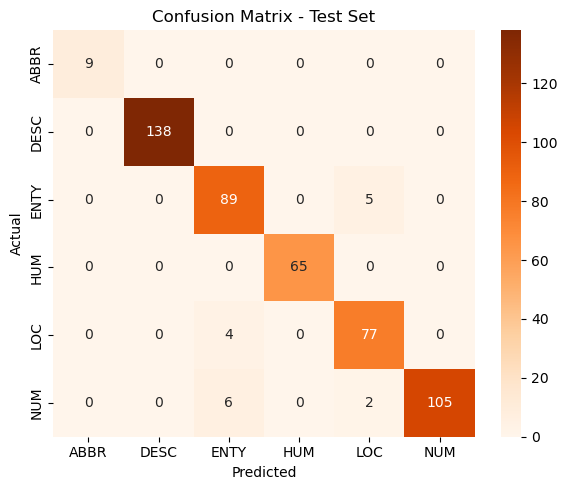

In [36]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.functional as F

best_model.eval()
test_preds, test_labels = [], []
wrong_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        labels = labels.long()
        logits = best_model(inputs)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        for i in range(len(preds)):
            if preds[i] != labels[i]:
                wrong_predictions.append({
                    "input": inputs[i],
                    "true_label": labels[i].item(),
                    "pred_label": preds[i].item()
                })

# Accuracy
acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {acc:.4f}")

# Classification Report
target_names = test_dataset.string_classes
print(classification_report(test_labels, test_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


In [37]:
def decode_input(input_tensor):
    tokens = input_tensor.cpu().tolist()
    return ' '.join([test_dataset.idx2word.get(tok, "[UNK]") for tok in tokens if tok != 0])

print(f"\nFound {len(wrong_predictions)} misclassified samples:\n")
for i, item in enumerate(wrong_predictions):  # limit output
    text = decode_input(item["input"])
    true_label = test_dataset.string_classes[item["true_label"]]
    pred_label = test_dataset.string_classes[item["pred_label"]]
    print(f"❌ Sample {i+1}")
    print(f"Text       : {text}")
    print(f"True Label : {true_label}")
    print(f"Predicted  : {pred_label}")
    print("-" * 50)



Found 17 misclassified samples:

❌ Sample 1
Text       : other what is the longest major league baseball winning streak
True Label : ENTY
Predicted  : LOC
--------------------------------------------------
❌ Sample 2
Text       : other what imaginary line is <UNK> between the north and south <UNK>
True Label : LOC
Predicted  : ENTY
--------------------------------------------------
❌ Sample 3
Text       : other what is the life expectancy of a dollar bill
True Label : NUM
Predicted  : ENTY
--------------------------------------------------
❌ Sample 4
Text       : other what is the life expectancy for <UNK>
True Label : NUM
Predicted  : ENTY
--------------------------------------------------
❌ Sample 5
Text       : temp the sun 's <UNK> what is the temperature
True Label : NUM
Predicted  : ENTY
--------------------------------------------------
❌ Sample 6
Text       : other what is the major <UNK> line near kentucky
True Label : ENTY
Predicted  : LOC
-----------------------------------

In [35]:
import random

# Inverse label mapping
idx_to_class = {i: label for i, label in enumerate(test_dataset.string_classes)}

print("\n🧪 Sample Test Results (with <UNK>):\n")

unk_count = 0

indices = list(range(len(test_dataset)))
random.shuffle(indices)

for i in indices[:10]:
    input_ids = test_dataset.numeral_questions[i]
    tokens = []
    for idx in input_ids:
        if idx == 0:
            continue  # Skip padding
        word = test_dataset.idx2word.get(idx, "<UNK>")
        if word == "<UNK>":
            unk_count += 1
            tokens.append(f"<UNK>")
        else:
            tokens.append(word)

    question_text = " ".join(tokens)

    true_label_idx = test_dataset.numeral_labels[i]
    true_label = idx_to_class[true_label_idx]

    # Predict
    input_tensor = torch.tensor(input_ids).unsqueeze(0)
    best_model.eval()
    with torch.no_grad():
        logits = best_model(input_tensor)
        pred_idx = torch.argmax(logits, dim=1).item()
        pred_label = idx_to_class[pred_idx]

    print(f"🔹 Question  : {question_text}")
    print(f"✅ True Label: {true_label}")
    print(f"🧠 Predicted : {pred_label}")
    print("-" * 50)

print(f"\n🔍 Total <UNK> tokens in these 10 samples: {unk_count}")



🧪 Sample Test Results (with <UNK>):

🔹 Question  : def what is <UNK>
✅ True Label: DESC
🧠 Predicted : DESC
--------------------------------------------------
🔹 Question  : def what are solar cells
✅ True Label: DESC
🧠 Predicted : DESC
--------------------------------------------------
🔹 Question  : def what are enzymes
✅ True Label: DESC
🧠 Predicted : DESC
--------------------------------------------------
🔹 Question  : def what is <UNK> major
✅ True Label: DESC
🧠 Predicted : DESC
--------------------------------------------------
🔹 Question  : other where did howard hughes die
✅ True Label: LOC
🧠 Predicted : LOC
--------------------------------------------------
🔹 Question  : ind who killed john f kennedy
✅ True Label: HUM
🧠 Predicted : HUM
--------------------------------------------------
🔹 Question  : other where was the first golf course in the united states
✅ True Label: LOC
🧠 Predicted : LOC
--------------------------------------------------
🔹 Question  : substance what kind of